# Kinematics demo

## Setup

In [1]:
import aopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import os

sns.set_context('paper')

In [35]:
# import bmi3d db functions to find the data
from bmi3d.db import dbfunctions as db

raw data is located in `/data/raw/`
files include:
* `/data/raw/ecube/2021-07-12_BMI3D_te2001`
* `/data/raw/hdf/beig20210712_te2001.hdf`
* `/data/raw/optitrack/Export/Take 2021-07-12 11_18_19 (2001).csv`


## Preprocessing

In [36]:
data_dir = "/data/raw"
preproc_dir = "/data/preprocessed/beignet"

# find all beignet's 'manual control' files from july 12
task_date = date.fromisoformat('2021-07-12')
entries = db.get_task_entries(subj='beignet', task='manual control', date=task_date)
for e in entries:
    print(e)

2021-07-12 11:18:13.677293: beignet on manual control task, id=2001
2021-07-12 11:30:22.666758: beignet on manual control task, id=2002
2021-07-12 11:36:56.524862: beignet on manual control task, id=2003
2021-07-12 11:48:36.244694: beignet on manual control task, id=2004


In [37]:
# pick number 2003
e = entries[-2]
raw_files = e.get_data_files_dict(data_dir)
preprocessed_filename = "preprocessed_te" + str(e.id) + ".hdf"

# preprocess the experiment data
aopy.preproc.proc_exp(data_dir, raw_files, preproc_dir, preprocessed_filename)

File preprocessed_te2003.hdf already exists, doing nothing.


In [38]:
# load the preprocessed experiment data and metadata
exp_data = aopy.data.load_hdf_group(preproc_dir, preprocessed_filename, 'exp_data')
exp_metadata = aopy.data.load_hdf_group(preproc_dir, preprocessed_filename, 'exp_metadata')
exp_data.keys()

dict_keys(['bmi3d_clock', 'bmi3d_events', 'bmi3d_state', 'bmi3d_task', 'bmi3d_trials', 'clock', 'events', 'measure_clock_offline', 'measure_clock_online', 'reward_system', 'state', 'sync_clock', 'sync_events', 'task', 'trials'])

In [39]:
exp_data['task'].dtype

dtype([('cursor', '<f8', (3,)), ('sync_square', '?', (1,)), ('manual_input', '<f8', (3,)), ('trial', '<u4', (1,)), ('plant_visible', '?', (1,))])

In [8]:
cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle
hand_kinematics = exp_data['task']['manual_input'] # hand kinematics (x, y, z) in Optitrack coordinates received by bmi3d before transformation to 2D
time = exp_data['clock']['timestamp']

## Plot all kinematic data

Text(0.5, 0.92, 'Hand kinematics in 3D space')

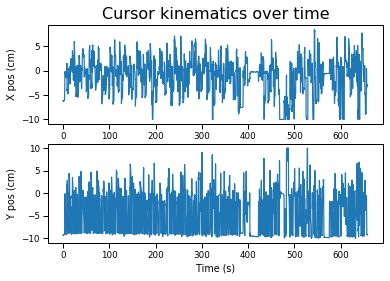

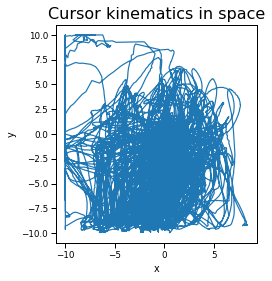

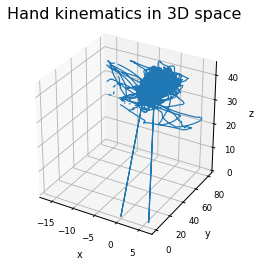

In [42]:
fig, ax = plt.subplots(2,1)
ax[0].plot(time, cursor_kinematics[:, 0])
ax[0].set_ylabel('X pos (cm)')
ax[1].plot(time, cursor_kinematics[:, 1])
ax[1].set_ylabel('Y pos (cm)')
ax[1].set_xlabel('Time (s)')
ax[0].set_title('Cursor kinematics over time', fontsize=16)

fig, ax = plt.subplots(1,1)
aopy.visualization.plot_trajectories([cursor_kinematics])
ax.set_title('Cursor kinematics in space', fontsize=16)

fig = plt.figure()
ax = plt.axes(projection='3d')
aopy.visualization.plot_trajectories([hand_kinematics])
ax.set_title('Hand kinematics in 3D space', fontsize=16)

## Separate trajectories by trial

In [10]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

In [23]:
clock = exp_data['clock']
print(clock.dtype)
events = exp_data['events']
print(events.dtype)

[('time', '<u8'), ('timestamp', '<f8'), ('prev_tick', '<f8'), ('timestamp_bmi3d', '<f8'), ('timestamp_sync', '<f8'), ('timestamp_measure_online', '<f8'), ('timestamp_measure_offline', '<f8')]
[('time', '<u8'), ('event', 'S32'), ('data', '<u4'), ('code', 'u1'), ('timestamp_bmi3d', '<f8'), ('timestamp_sync', '<f8'), ('timestamp', '<f8')]


In [22]:
event_names = events['event']
event_times = clock['timestamp_measure_offline'][events['time']] - exp_metadata['bmi3d_start_time'] # this is confusing
trial_segments, trial_times = aopy.preproc.get_trial_segments(events['code'], event_times, [CENTER_TARGET_OFF], [REWARD])
trial_segments = np.array(trial_segments)
print(trial_segments[:10])
print(trial_times[:10])

[[32 86 48]
 [32 83 48]
 [32 82 48]
 [32 87 48]
 [32 81 48]
 [32 88 48]
 [32 84 48]
 [32 85 48]
 [32 81 48]
 [32 82 48]]
[[ 3.64984  4.43756]
 [ 7.6248   8.69552]
 [11.60404 12.5748 ]
 [15.09144 16.54144]
 [19.24144 19.93704]
 [23.40808 23.95808]
 [26.75804 27.32472]
 [30.55804 30.97036]
 [33.49964 34.1788 ]
 [37.02052 37.89136]]


In [24]:
cursor_trajectories = aopy.preproc.get_data_segments(cursor_kinematics, trial_times, exp_metadata['fps'])
hand_trajectories = aopy.preproc.get_data_segments(hand_kinematics, trial_times, exp_metadata['fps'])

In [43]:
# get the unique target positions
trials = exp_data['trials']
n_trials = len(trials)
trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
unique_targets = np.unique([t[1] for t in trial_targets], axis=0)

## Plot 50 trial trajectories

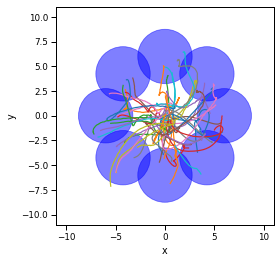

In [44]:
bounds = exp_metadata['cursor_bounds'][[0,1,4,5]]
aopy.visualization.plot_trajectories(cursor_trajectories[:50], bounds=bounds)
aopy.visualization.plot_targets(unique_targets, exp_metadata['target_radius'])

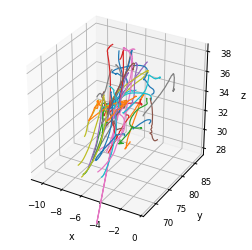

In [34]:
bounds_3d = [-10, 0, 60, 80, 25, 35]
fig = plt.figure()
ax = plt.axes(projection='3d')
aopy.visualization.plot_trajectories(hand_trajectories[:50], bounds=bounds_3d)